Codebasis zur Berechnung von Renditen und Renditedreiecken.

In [44]:

# -*- coding: utf-8 -*-
"""
This cell contains class definitions for the calculation the evolution and outcome of a savings plan. 
A saving plan with a fix return percentage or within stock buyings are supported. 
All imported packages are available on PyPI and can be installed through "pip install ..." 
"""
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
import quandl #provides an API for finance data
import pandas as pd
from pandas_datareader import data as pdr #uses several APIs for finance data, for instance yahoo_finance
import fix_yahoo_finance as yf #since yahoo finance isn't working and maintained anymore, it was fixed by this package
import irr #a very fast package for the calculation of "internal rate of return, much faster than in numpy" (Interner Zinsfuß)
           # Documentation: https://github.com/better/irr
yf.pdr_override() 
plt.style.use('default') #Use another matplotlib style for 
quandl.ApiConfig.api_key = 'TAJWxRm_yayb-Avh1pkT' #Franz' quandl API-key (Feel free to use your own)

class CumulativeCalculation:
    """
    Creates and calculates a dataframe of a savings plan
    """
    def __init__(self, initial_balance, start, stop, deposit, repetition, interest=0.0):
        """
        Initialization of the attributes used in the calculation. Calls self.create_deposit.
        Creates a pandas Dataframe within the defined datetime-limits.
        """
        self.initial_balance = initial_balance
        self.interest = interest
        self.deposit = deposit
        self.rep = repetition
        self.start = start
        self.end = stop
        self.index = pd.date_range(start=self.start, end=self.end, freq='D')
        self.deposit_locations = pd.date_range(start=start, end=stop, freq=self.rep) #deposit timestamps
        self.df = pd.DataFrame(index=self.index)
        self.df["value"] = 0.0
        self.df["deposit"] = 0.0
        self.create_deposit()
        
    def create_deposit(self):
        """
        Writes the initial balance and all deposits to the dataframe.
        """
        self.df["deposit"][self.deposit_locations] = self.deposit
        self.df["value"][self.start] = self.initial_balance
        
    def calc_interest(self):
        """
        Iteratively determines (day by day) the evolution of the balance in dependence on the deposits,
        the initial balance and the interest rate.
        """
        days_per_year = 365.249
        for current_day in self.df.index[1:]:
            current_yesterday = current_day - 1
            self.df["value"][current_day] = (self.df["value"][current_yesterday] 
                                                + self.df["deposit"][current_yesterday])\
                                                *(1+(self.interest/100))**(1/days_per_year)
        self.df.index.name = "Date"


class CumulativeStockCalculation(CumulativeCalculation):
    """
    Child class of CumulativeCalculation that adds stock buying to the savings plan. The whole amount of the savings
    rate is spend for the defined stock.
    """
    def __init__(self, data_source, yahoo_stock, initial_balance, start, stop, deposit, repetition, preloaded_data=None):
        """
        Initialization for the Calculation of cumulative returns of a defined stock.
        The historical data of the given stock is stored inside a csv file to save time if
        it is used later.
        """
        self.data_source = data_source
        self.stock = yahoo_stock
        self.yahoo_default_start_date = "1971-01-01"
        if not os.path.exists('stocks_data'):
            os.makedirs('stocks_data')
        if not os.path.exists('stocks_data/{}.csv'.format(yahoo_stock.replace("/", "1"))):
            self.stock_data = self.load_stock_data()
            self.stock_data.to_csv('stocks_data/{}.csv'.format(yahoo_stock.replace("/", "1")), header=False)
        else:
            if preloaded_data is None:
                self.stock_data = pd.read_csv('stocks_data/{}.csv'.format(yahoo_stock.replace("/", "1")), index_col=0,
                                              header=None, names=["Close"])["Close"]#, names=["Date", "Close"])
            else:
                self.stock_data = preloaded_data
            self.stock_data.index.name = "Date"
            self.stock_data.index = pd.to_datetime(self.stock_data.index)
        self.cropped_stock_data = self.stock_data[np.all([start <= self.stock_data.index,
                                                  self.stock_data.index <= stop], axis=0)]
        super().__init__(initial_balance, start, stop, deposit, repetition)
        self.df["stock_price"] = self.cropped_stock_data
        self.df["stock_price"] = self.df["stock_price"].fillna(method="bfill")
        self.df.stock_price = self.df.stock_price.fillna(method="ffill")
        self.df["number_of_stocks"] = 0.0
        self.df["number_of_stocks"][self.start] = self.initial_balance / self.df["stock_price"][self.start]
        
    def load_stock_data(self):
        """
        This method loads stock data from the chosen source. Only yahoo and quandl are supported yet.
        Called inside of self.__init__
        """
        if "yahoo" in self.data_source:
            data = pdr.get_data_yahoo(self.stock,pd.to_datetime(self.yahoo_default_start_date))["Close"]
        elif "quandl" in self.data_source:
            data = quandl.get(self.stock)["Value"]
        else:
            raise ValueError("Unknown Data Source")
        return data
    
    def calc_interest(self):
        """
        This method determines the evolution of the given stock savings plan over the defined time.
        Overrides the calc_interest method inside of CumulativeCalculation.
        """
        initial_number_of_stocks = self.df["value"][self.start]/self.df["stock_price"][self.start]
        self.df["buy"] = self.df.deposit/self.df.stock_price
        self.df["number_of_stocks"] = self.df.buy.cumsum()
        self.df["value"] = self.df.number_of_stocks*self.df.stock_price
        self.df.index.name = "Date"
        
    def calc_avg_return(self):
        """
        This method determines the average return (per year) of the stock savings plan. The irr.irr
        method is much faster than the one contained in numpy. Numerically solves the optimization 
        problem of determining the average return of an investment where the numer of stocks changes over time.
        """
        irr_value = irr.irr([-self.deposit]*self.deposit_locations.size+[self.df.value[-1]])
        avg_return = (irr_value+1)**12
        #print(self.start," --> ", self.end, 'irr: ',
        #      irr_value, "--> return/a: ", (avg_return-1)*100)
        return avg_return
    
    def plot_stock(self):
        """Plots the given close stock price within the given time window."""
        plt.figure(3, figsize=(15,9))
        self.df.stock_price.plot()
        plt.yscale("log")
        plt.ylim(1e2,1e4)
        return df

        
class RenditeDreieck:
    """
    Class that defines a Renditedreieck, kind of a triangle of returns. In a given time frame, 
    the average return of a savings plan is calculated for all sub time frames.
    For instance if a time frame of 1970 to 1990 is given, the following average returns are calculated:
    1970 -> 1971
    1970 -> 1972
    ...
    1971 -> 1972
    1971 -> 1973
    ...
    ...
    1989 -> 1990
    """
    
    def __init__(self, data_source, yahoo_stock, start, end, deposit, repetition, period):
        """
        The init method creates the dataframe which is used for
        
        Args:
            data_source (str): Data source, only "yahoo" and "quandl" are supported yet
            yahoo_stock (str): WKN of the stock
            start (pd.Timestamp): Start date
            end (pd.Timestamp): End date
            deposit (float): periodically deposit (amount not number of stocks).
                The deposit doesn't affect the average return as long as taxes and fees
                are not taken into account. It might be important for future child classes of 
                Renditedreieck
            repetition (str): Period of deposit, "MS" for every month
            period (str): Period of triangle determination, "Y" for year, "M" for month
        Examples:
            >>> begin_date = pd.Timestamp("1984-10-30")
            >>> end_date = pd.Timestamp("2019-01-03")
            >>> deposit = 100.
            >>> my_dreieck = RenditeDreieck("yahoo_finance", "^GSPC", begin_date, end_date, deposit, "MS", "Y")
        """ 
        self.data_source = data_source
        self.yahoo_stock = yahoo_stock
        self.deposit = deposit
        self.repetition = repetition
        self.start = pd.to_datetime(start)
        self.end = pd.to_datetime(end)
        self.time_diff = self.end.year - self.start.year
        self.time_range_withdraw = pd.date_range(start=self.start, end=self.end, freq=period)
        self.time_range_deposit = self.time_range_withdraw - 1
        self.triangle_array = np.zeros((self.time_diff, self.time_diff))
        self.filename = ""
    
    def calc_triangle(self, new):
        """
        Contains loop that calculates the average return for the sub time frames.
        Saves the results in a csv-file.
        """
        preloaded_data = None
        if new:                
            for i, startdate in enumerate(self.time_range_deposit):
                for k, enddate in enumerate(self.time_range_withdraw):
                    if k >= i:
                        current_curve = CumulativeStockCalculation(self.data_source,
                                                                   self.yahoo_stock, 0, 
                                                                   startdate, enddate, 
                                                                   self.deposit, self.repetition,
                                                                   preloaded_data)
                        current_curve.calc_interest()
                        self.triangle_array[i,k] = current_curve.calc_avg_return()
                        if preloaded_data is None:
                            preloaded_data = current_curve.stock_data
            self.filename = "trianfile_"+self.yahoo_stock.replace("/", "1")+".csv"
            np.savetxt(self.filename, (self.triangle_array-1)*100)
                    
    def draw_step(self, offset, gridsize):
        """
        Plots a step plot inside of the triangle of returns to seperate investment horizons
        of 5 years.
        (the triangle of return)
        """
        x = np.arange(4.5+offset,gridsize+.5)
        y= np.arange(-0.5,gridsize-4.5-offset)
        plt.step(x,y, lw=2, color="w")

    def plot_triangle(self, filename=None):
        """
        Aranges the plot of the triangle of return.
        """
        if filename:
            self.filename=filename
        A = np.round(np.genfromtxt(self.filename),1)
        mask =  np.tri(A.shape[0], k=-1)
        A = np.fliplr(np.fliplr(A).T)
        A = np.ma.array(A, mask=mask) # mask out the lower triangle
        fig = plt.figure(self.yahoo_stock, figsize=(9.5,6))
        ax1 = fig.add_subplot(111)
        # custom nonlinear colormap, optimized to visualize small changes around a return of 0% as well as bigger changes. Better than a log scale.
        c=np.matrix("[142,0,0;143,1,0;144,2,0;145,3,0;146,4,0;147,4,0;148,5,0;149,6,0;150,7,0;151,8,0;152,9,0;153,10,0;154,11,0;155,12,0;156,12,0;157,13,0;158,14,0;159,15,0;160,16,0;161,17,0;162,18,0;163,19,0;164,19,0;165,20,0;166,21,0;167,22,0;168,23,0;169,24,0;170,25,0;171,26,0;172,27,0;173,27,0;174,28,0;175,29,0;176,30,0;177,31,0;178,32,0;179,33,0;179,34,0;180,35,0;181,35,0;182,36,0;183,37,0;184,38,0;185,39,0;186,40,0;187,41,0;188,42,0;189,42,0;190,43,0;191,44,0;192,45,0;193,46,0;194,47,0;195,48,0;196,49,0;197,50,0;198,50,0;199,51,0;200,52,0;201,53,0;202,54,0;203,55,0;204,56,0;205,57,1;206,60,5;207,63,9;207,67,13;208,70,17;209,73,21;210,76,25;211,79,29;211,82,33;212,85,37;213,88,41;214,92,45;215,95,49;215,98,53;216,101,57;217,104,61;218,107,65;219,110,69;219,113,73;220,117,77;221,120,81;222,123,85;223,126,89;223,129,93;224,132,97;225,135,101;226,139,105;227,142,109;227,145,113;228,148,117;229,151,121;230,154,125;231,157,129;231,160,133;232,164,137;233,167,141;234,170,145;235,173,149;235,176,153;236,179,157;237,182,161;238,185,165;239,189,170;239,192,174;240,195,178;241,198,182;242,201,186;243,204,190;243,207,194;244,210,198;245,214,202;246,217,206;247,220,210;247,223,214;248,226,218;249,229,222;250,232,226;251,235,230;251,239,234;252,242,238;253,245,242;254,248,246;255,251,250;255,254,254;254,255,254;251,253,250;248,252,246;244,250,242;241,248,238;238,247,234;235,245,230;231,244,226;228,242,222;225,240,218;222,239,214;218,237,210;215,235,206;212,234,202;209,232,198;205,230,194;202,229,190;199,227,186;196,226,182;192,224,178;189,222,174;186,221,170;183,219,166;179,217,161;176,216,157;173,214,153;170,212,149;166,211,145;163,209,141;160,207,137;157,206,133;153,204,129;150,203,125;147,201,121;144,199,117;140,198,113;137,196,109;134,194,105;131,193,101;127,191,97;124,190,93;121,188,89;118,186,85;114,185,81;111,183,77;108,181,73;105,180,69;101,178,65;98,176,61;95,175,57;92,173,53;88,172,49;85,170,45;82,168,41;79,167,37;75,165,33;72,163,29;69,162,25;66,160,21;62,158,17;59,157,13;56,155,9;53,153,5;49,152,1;48,151,0;47,150,0;47,149,0;46,148,0;45,147,0;44,146,0;44,145,0;43,144,0;42,143,0;41,142,0;40,141,0;40,139,0;39,138,0;38,137,0;37,136,0;37,135,0;36,134,0;35,133,0;34,132,0;34,131,0;33,130,0;32,129,0;31,128,0;31,127,0;30,126,0;29,125,0;28,124,0;27,123,0;27,122,0;26,121,0;25,120,0;24,119,0;24,118,0;23,117,0;22,116,0;21,115,0;21,114,0;20,113,0;19,112,0;18,111,0;18,110,0;17,109,0;16,108,0;15,107,0;15,106,0;14,105,0;13,104,0;12,103,0;11,102,0;11,101,0;10,100,0;9,99,0;8,98,0;8,97,0;7,96,0;6,95,0;5,94,0;5,93,0;4,92,0;3,91,0;2,90,0;2,89,0;1,88,0;0,87,0]")
        my_cm = mpl.colors.ListedColormap(c/255.0)
        gridsize = np.shape(A)[0]
        cmap = cm.get_cmap(my_cm, 100000) # jet doesn't have white color
        x_ticks = list(self.time_range_deposit.year[::-1])
        y_ticks = list(self.time_range_withdraw.year[::-1])
        print(x_ticks)
        print(y_ticks)
        ax1.imshow(A, interpolation="nearest", cmap=cmap, aspect="auto", 
                   origin="lower", vmin=-20, vmax=20)
        ax1.yaxis.tick_right()
        ax1.set_xticks(range(gridsize))
        ax1.set_yticks(range(gridsize))
        ax1.set_xticklabels(x_ticks, rotation=90)
        ax1.set_yticklabels(y_ticks)
        plt.setp(ax1.get_xticklabels(), rotation=45, ha="right",
                rotation_mode="anchor")
        ax1.spines['right'].set_visible(False)
        ax1.spines['top'].set_visible(False)
        ax1.spines['left'].set_visible(False)
        ax1.spines['bottom'].set_visible(False)
        ax1.set_title(self.yahoo_stock)
        a,b = np.shape(A)
        for i in range(a):
            for j in range(b):
                if A[i, j]:
                    if abs(A[i,j]) > 15:
                        text = ax1.text(j, i, A[i, j],
                                        ha="center", va="center", color="w", fontsize=7)
                    else:
                        text = ax1.text(j, i, A[i, j],
                                        ha="center", va="center", color="k", fontsize=7)
                if A[i,j] == 0:
                    print(i,j)
                    ax1.text(j, i, abs(A[i, j]),
                             ha="center", va="center", color="k", fontsize=7)

        for i in np.arange(0,gridsize,5):
            self.draw_step(i,gridsize)
        plt.savefig("renditedreieck_"+self.yahoo_stock.replace("/", "1")+".pdf", dpi=300)
        plt.tight_layout()
        plt.show()



def load_stock_data(self, source,  start, end):
    """
    Connects to yahoo server and requests historical stock prices.
    """
    self.stock_data = pdr.get_data_yahoo(yahoo_stock,pd.to_datetime(start),pd.to_datetime(end))["Close"]
    super().__init__(initial_balance, start, stop, deposit, repetition)
    self.df["stock_price"] = self.stock_data
    self.df["stock_price"] = self.df["stock_price"].fillna(method="bfill")
    self.df.stock_price = self.df.stock_price.fillna(method="ffill")
    return 

Style festlegen und interaktiven notebook-plot auswählen.

In [2]:
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")
# Interactive version. If you like to have static plots, use the magic %matplotlib inline
# Since javascript support isn't ported to jupyterlab yet, use %matplotlib inline or ipymplin jupyterlab
%matplotlib inline

In [3]:
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 110
mpl.rcParams['lines.linewidth'] = 2.0


# Proposal

"Sparen am Aktienmarkt - Eine Zeitserienanalyse mit Python"

In diesem Workshop geht es um Finanzbildung mit Fokus auf Aktienmarkt und Fonds. Ich möchte einen Einblick in das Sparen am Aktienmarkt und die damit verbundenen Chancen und Risiken geben. Mit Rücksicht auf das Verständnis nähern wir uns dem Thema graphisch und analysieren Zeitserien bzw. Aktienkurse mit Python und jupyter-notebooks.
Der Workshop soll aus folgenden Teilen bestehen:
1. Im Rahmen eines kurzen Planspieles möchte ich zeigen, warum Sparen am Aktienmarkt auch gesellschaftliche Partizipation bedeutet und warum Aktien nicht nur "für reiche sind".
2. Welche gesellschaftlichen Probleme ergeben sich infolge unterschiedlicher Finanzbildung?
3. Woher bekommt man aktuelle und historische Kursdaten?
4. Wie setzt sich ein Indexfonds aus Aktien zusammen?
5. Wie berechne ich mit den Daten einen Beispielsparplan?
6. Wie schaffe ich mir einen übersichtlichen Blick in die Vergangenheit? Rendite und Renditedreieck.

"Ich würde gern mit Ihnen über Geld sprechen"



## Planspiel

Monatliches Einkommen dreier verschiedener Biographien:
1. Einzelhandel-Mitarbeiterin: 2000 Euro brutto im Schnitt
2. Öffentlicher Dienst Wissenschaftliche Mitarbeiterin E13: 4000 Euro brutto
3. Öffentlicher Dienst Wissenschaftliche Mitarbeiterin E13: 4000 Euro brutto + 100000 Euro Erbe 
4. Friedrich Merz: 1e6 Euro (Fiktives Einkommen eines fiktiven Charakters mit dem hier zufällig gewählten Namen.)

Voraussetzung: Soziale Ungleichheit durch Einkommens- und Vermögensverteilung, politisches Problem

### Sparen ohne Zins

Annahme: Einzelhandelsmitarbeiterin Kann 50 Euro im Monat zurücklegen

In [4]:
einzelhandel = CumulativeCalculation(initial_balance=0, start="2019-01-01", stop="2039-01-01", deposit=50, repetition="M")

In [5]:
einzelhandel.calc_interest()

In [6]:
einzelhandel.df.head()

,value,deposit
Date,,
2019-01-01,0.0,0.0
2019-01-02,0.0,0.0
2019-01-03,0.0,0.0
2019-01-04,0.0,0.0
2019-01-05,0.0,0.0


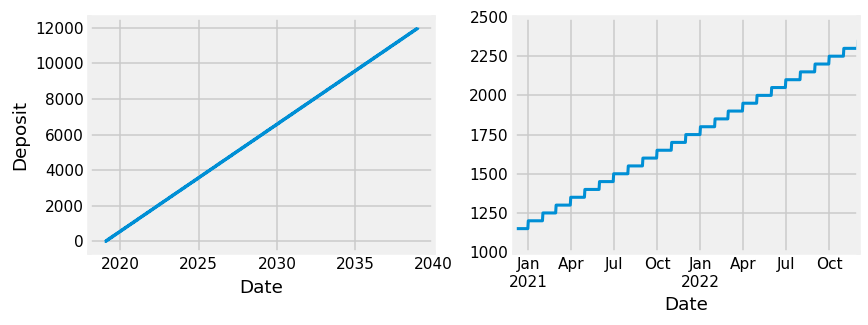

In [7]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=False, figsize=(8,3))
einzelhandel.df.value.plot(ax=ax1)
ax1.set_ylabel("Deposit")
ax1.set_xlabel("Date")
einzelhandel.df.value.plot(ax=ax2)
ax2.set_xlim("2020-12-01","2022-12-01")
ax2.set_ylim(1000,2500)
plt.tight_layout()


Prizip Sparplan gut erkennbar: Es kommt monatlich ein fixer Betrag dazu.

In [8]:
wiss = CumulativeCalculation(initial_balance=0, start="2019-01-01", stop="2039-01-01", deposit=200,repetition="M")
wiss.calc_interest()
merz = CumulativeCalculation(initial_balance=0, start="2019-01-01", stop="2039-01-01", deposit=1e6/4/12,repetition="M")
merz.calc_interest()
wiss_mit_erbe = CumulativeCalculation(initial_balance=1e5, start="2019-01-01", stop="2039-01-01", deposit=200,repetition="M")
wiss_mit_erbe.calc_interest()


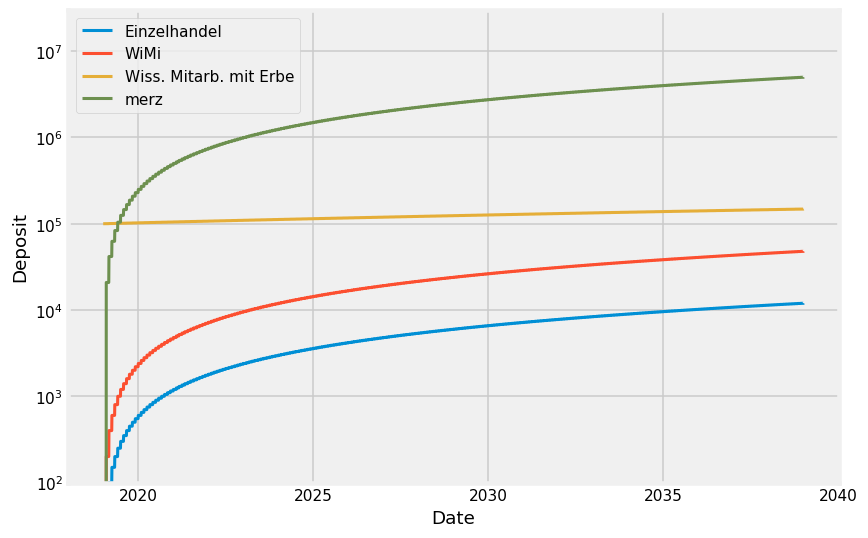

In [9]:
#Lin Scale
fig = plt.figure(num="Deposit1",figsize=(8,5))
einzelhandel.df.value.plot(label="Einzelhandel")
wiss.df.value.plot(label="WiMi")
wiss_mit_erbe.df.value.plot(label="Wiss. Mitarb. mit Erbe")
merz.df.value.plot(label="merz")
plt.ylabel("Deposit")
plt.xlabel("Date")
plt.ylim(-0.1e7,0.5e7)
#Log-Scale
plt.ylim(100,3e7)
plt.yscale("log")
plt.legend()
plt.tight_layout()


Bis hierher ist alles wie erwartet:
- Die Vermögensschere geht mit der Zeit auf, weil die Einkommen ungleich sind
- Aber: Die Vermögensschere geht nicht überproportional auf (Kurven sind parallel)
- Das bleibt auch so, wenn wir die Inflation mit einbeziehen.
- Was ist der Unterschied?

Folgender Fall: Unterschiedliche Finanzbildung macht das Aufgehen der Schere überproportional:
- Merz spart in Aktien
- Wiss. Mitarbeiterin spart vielleicht in Aktien
- Einzelhandelskauffrau spart wahrscheinlich nicht in Aktien

### Sparen mit Zins 7% nur für merz

In [10]:
einzelhandel = CumulativeCalculation(initial_balance=0, start="2019-01-01", stop="2039-01-01", deposit=50,repetition="M", interest = 0.)
einzelhandel.calc_interest()
wiss = CumulativeCalculation(initial_balance=0, start="2019-01-01", stop="2039-01-01", deposit=200,repetition="M", interest = 0.)
wiss.calc_interest()
merz7 = CumulativeCalculation(initial_balance=0, start="2019-01-01", stop="2039-01-01", deposit=1e6/4/12,repetition="M", interest = 7.)
merz7.calc_interest()

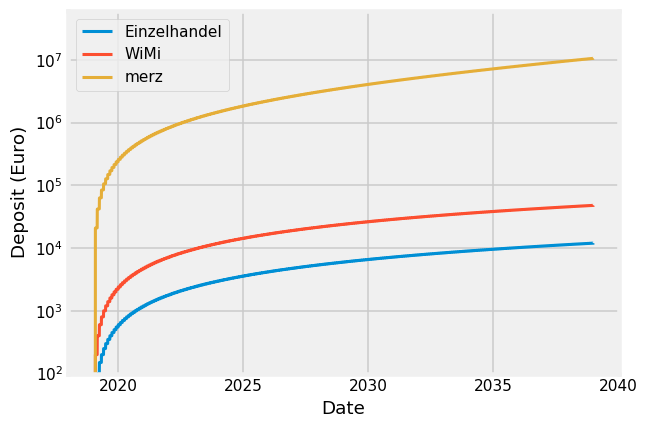

In [11]:
fig = plt.figure(num="deposit with 7% interest")
einzelhandel.df.value.plot(label="Einzelhandel")
wiss.df.value.plot(label="WiMi")
merz7.df.value.plot(label="merz")
plt.ylabel("Deposit (Euro)")
plt.xlabel("Date")
plt.ylim(-0.1e7,1.5e7)
plt.legend()
plt.ylim(100,6e7)
plt.yscale("log")
plt.tight_layout()

Sieht aus wie ohne Zins...?!

Aber wie ist das Verhältnis der verschiedenen Vermögen? Beispiel: Vermögen Friedrich Merz mit wissensch. Mitarbeiterin ohne Erbe

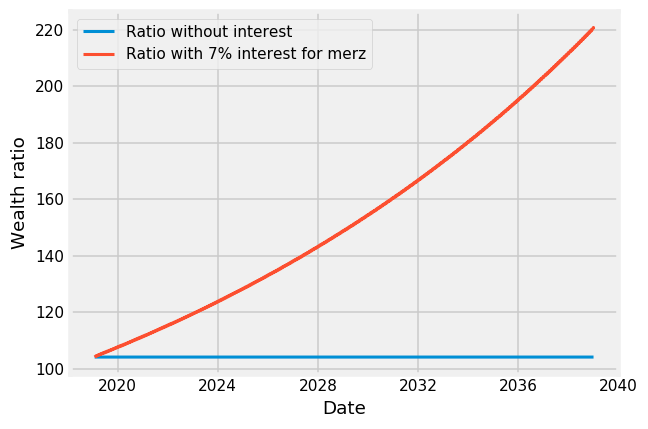

In [12]:
plt.figure("Wealth Ratio")
plt.plot(merz.df.value/wiss.df.value, label= "Ratio without interest")
plt.plot(merz7.df.value/wiss.df.value, label= "Ratio with 7% interest for merz")
plt.legend()
plt.xlabel("Date")
plt.ylabel("Wealth ratio")
plt.tight_layout()


Fazit: Mit zunehmender Anlagezeit geht die Vermögensschere immer weiter auf, unabhängig vom Einkommen!
- Das Bedeutet Mittelfristig eine Umverteilung von Gütern
- Noch wesentlicher: Umverteilung von Produktionsmitteln

Frage: Wie schafft Merz 7%?

### Sparen mit Zins 7% für alle

In [13]:
einzelhandel7 = CumulativeCalculation(initial_balance=0, start="2019-01-01", stop="2039-01-01", deposit=50,repetition="M", interest = 7.)
einzelhandel7.calc_interest()
wiss7 = CumulativeCalculation(initial_balance=0, start="2019-01-01", stop="2039-01-01", deposit=200,repetition="M", interest = 7.)
wiss7.calc_interest()
wiss_mit_erbe7 = CumulativeCalculation(initial_balance=1e5, start="2019-01-01", stop="2039-01-01", deposit=200,repetition="M", interest=7.)
wiss_mit_erbe7.calc_interest()
merz7 = CumulativeCalculation(initial_balance=0, start="2019-01-01", stop="2039-01-01", deposit=1e6/4/12,repetition="M", interest = 7.)
merz7.calc_interest()

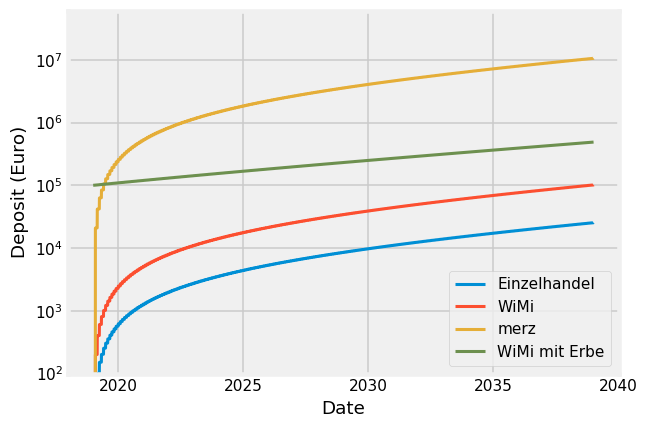

In [14]:
fig = plt.figure(num="deposit with 7% interest for all")
einzelhandel7.df.value.plot(label="Einzelhandel")
wiss7.df.value.plot(label="WiMi")
merz7.df.value.plot(label="merz")
wiss_mit_erbe7.df.value.plot(label="WiMi mit Erbe")
plt.ylabel("Deposit (Euro)")
plt.xlabel("Date")
plt.ylim(100,6e7)
plt.yscale("log")
plt.legend()
plt.tight_layout()

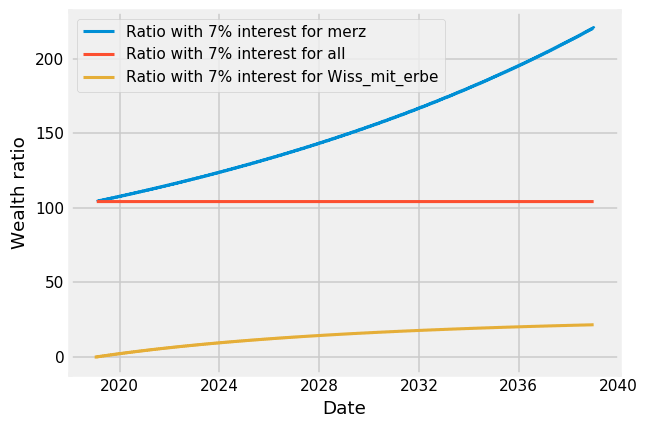

In [15]:
plt.figure("Wealth Ratio 7% for all")
plt.plot(merz7.df.value/wiss.df.value, label= "Ratio with 7% interest for merz")
plt.plot(merz7.df.value/wiss7.df.value, label= "Ratio with 7% interest for all")
plt.plot(merz7.df.value/wiss_mit_erbe7.df.value, label="Ratio with 7% interest for Wiss_mit_erbe")
plt.legend()
plt.xlabel("Date")
plt.ylabel("Wealth ratio")
plt.tight_layout()


1. Was ist Altersvorsorge und warum spreche ich heute hauptsächlich über Aktien?
   - Vorsorge für das Alter? Oder will ich das gar nicht? Will ich lieber Vorsorgen um mit 50 ein Haus in Kroatien zu kaufen?
2. Warum ist die Aktie anderen Assettklassen vorzuziehen?
3. Was macht der Kapitalismus? Die reichen werden reicher, die armen ärmer?
4. Folge der Industralisierung: Teilhabe am Produktivkapital --> Frage: Wie am Produktivkapital teilhaben wenn kein Geld? Fondsrechner! 50 Euro.

## Vermögensverteilung in Deutschland und Aktienbesitz

Quelle: [Süddeutsche Zeitung](https://www.sueddeutsche.de/wirtschaft/aktien-verteilung-deutschland-1.4076466)

![Verteilung](https://gfx.sueddeutsche.de/apps/e695940/www/_image_desktopw1840q70.png)

1. Karte zeigen auf der die Vermögenssituation dargestellt ist
2. Karte zeigen auf der der Aktienbesitz dargestellt ist.
3. Kurzum: Aktienbesitz hängt am Vermögen uuuuuuuund an der Finanzbildung

# Hauptteil

## Woher kommen Aktien? Warum gibt es Aktien?

Ohne näher in die Geschichte gehen zu wollen: Wenn man ein Unternehmen besitzt (keine Aktiengesellschaft), muss man sich manchmal Geld besorgen. Beispiel: Habe kleines Unternehmen und ersaufe in Aufträgen,

## Das Modell Volkseigentum

Sozialistischer Ansatz Volkseigentum:
 1. Bin kein Ökonom, aber in der DDR hat das sogenannte Volkseigentum dazu geführt, dass in vielen Betrieben das Material als niemandem zugehörig angesehen wurde. Bei meiner Oma im Porzellanwerk haben besoffene Brennmeister regelmäßig ganze Chargen verbrennen lassen. (Nochmal checken), 98% der Produktionsmittel VEB
 2. Im Sinne einer Allmende funktioniert das noch, da es eine soziale Kontrolle des Gemeinschaftseigentums in kleinen Dorfgemeinschaften gibt
 3. Darüber hinaus hat dieser Ansatz zu einem hohen Maß an wirtschaftskriminalität geführt --> Diebstähle in den VEB 
 4. Wie sieht das heute aus? Vor allem in den alten Bundesländern
 5. Keine Private Bindung ans Unternehmen.

Bis zur Gründung der DDR 1949 war bereits etwa die Hälfte aller Produktionsmittel in Volks- und Gemeineigentum überführt worden. Der Sprecher des „Amtes zum Schutz des Volkseigentums“ im sächsischen Landtag zeigte sich im März 1949

    „nicht davon überzeugt, daß allen Menschen das Volkseigentum bereits ans Herz gewachsen ist, daß sie es beginnen zu schützen. [...] Einer der größten Faktoren für Schäden, die in den volkseigenen Betrieben eintreten, liegt in der Nachlässigkeit der Menschen [...], in dem großen Abstand, den sie heute noch gegenüber dem Volkseigentum haben.[11]“

Stichwort: Volkseigen immer noch präsent, wenn geklaut wird.

## Die Aktie als Instrument der gesellschaftlichen Teilhabe

 1. Gegenüberstellung aller deutschen Rentenzahlungen mit den Fondskäufen in privathaushalten
 2. Was soll uns das? Asozial wenn alle in Aktien investieren, Rentensystem ist Generationenvertrag
 3. Aktienbesitz Ost-West --> Unterschiede in der Vermögensentwicklung
 4. Stefan Schulz (u.a. Aufwachen-Podcast) argumentiert mit gesellschaftlicher Teilhabe unabhängig von Aktien --> Wenn der Markt seit der Wende wächst, der Osten aber keinen Teil vom Kuchen abbekommt, wieso sollte Demokratie dann mit Wohlstand identifiziert werden? --> Fehlende Identifikation mit ortsansässigen Unternehmen und Deutschlandweit agierenden Unternehmen.
 5. Verstärkt Ohnmachtgefühle, fehlendes Mitspracherecht bei Hauptversammlungen.
 6. Marktanteile von privathaushalten fehlen überwiegend in Deutschland, im Osten ganz


# Aktien

![Aktie](https://upload.wikimedia.org/wikipedia/commons/f/fe/RWE_1910.jpg)

## Daten - woher?

- Wir brauchen historische bzw. aktuelle Aktienkurse beliebiger Aktien.
- Dazu gibt es schon Bibliotheken in python, pandas_datareader
- Verschiedene *Datenhändler* wie **quandl**, **alphavantage** bieten API-Keys und wollen extra-Pakete verkaufen
- Web-scraping von **google_finanace**, **yahoo_finanace**, **wikipedia**, auch da gibt es bereits Bibliotheken wie *pandas_datareader*

In [16]:
import fix_yahoo_finance as yf
from pandas_datareader import data as pdr
#import pandas_datareader as pdr
data_nvda = pdr.get_data_yahoo("NVDA","1970-12-12","2018-12-14")
data_nvda_source = pdr.get_data_alphavantage("NVDA",function='TIME_SERIES_DAILY',
                                             start="1970-12-12",end="2018-12-14", api_key="1X6D9DKKAQD7BPWV")
data_nvda_source.index = pd.to_datetime(data_nvda_source.index)


data_nvda_source.head()

[*********************100%***********************]  1 of 1 downloaded


,open,high,low,close,volume
1999-01-22,21.00,23.44,18.63,19.69,5655600
1999-01-25,21.25,22.00,19.69,21.75,1063500
1999-01-26,22.00,22.44,19.75,20.06,715000
1999-01-27,20.13,20.63,19.00,20.00,509100
1999-01-28,20.00,20.13,19.81,19.94,474000


In [17]:
data_nvda.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-12-07,158.460007,158.869995,145.619995,147.610001,147.458023,17041900
2018-12-10,145.800003,152.860001,145.649994,151.860001,151.703659,15736800
2018-12-11,155.559998,155.889999,145.000000,148.190002,148.037430,16797800
2018-12-12,148.419998,152.779999,144.820007,148.899994,148.746689,16353400
2018-12-13,150.789993,153.380005,147.440002,148.889999,148.736710,11784600


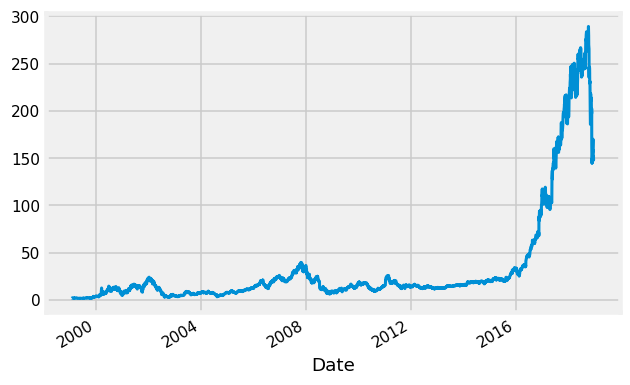

In [18]:
data_nvda["Close"].plot()

In [19]:
data_gold = pdr.get_data_quandl("WGC/GOLD_DAILY_USD", api_key='TAJWxRm_yayb-Avh1pkT')

In [20]:
data_gold.head()

,Value
Date,
2019-02-22,1329.05
2019-02-21,1331.25
2019-02-20,1343.75
2019-02-19,1334.15
2019-02-18,1325.50


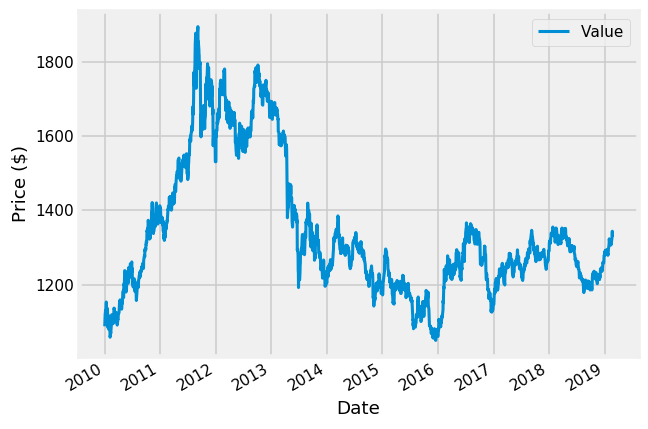

In [21]:
data_gold.plot(label="Gold")
plt.ylabel("Price ($)")
plt.tight_layout()

Text(0, 0.5, 'Schlusskurs ($)')

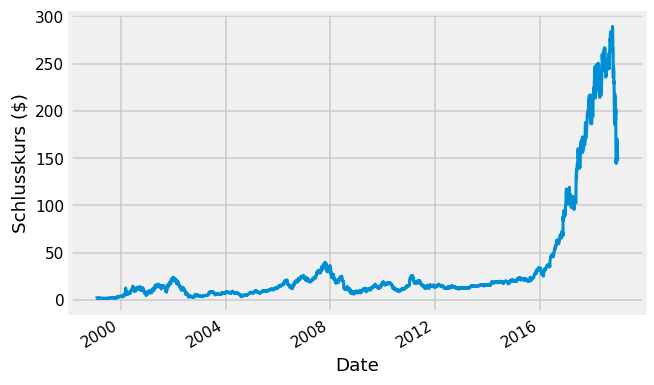

In [22]:
data_nvda["Close"].plot()
plt.ylabel("Schlusskurs ($)")

## Beispiele:

NASDAQ:
- Nvidia
- Vodafone...

In [23]:
data_vod = pdr.get_data_yahoo("VOD","2000-12-12","2018-12-28")


[*********************100%***********************]  1 of 1 downloaded


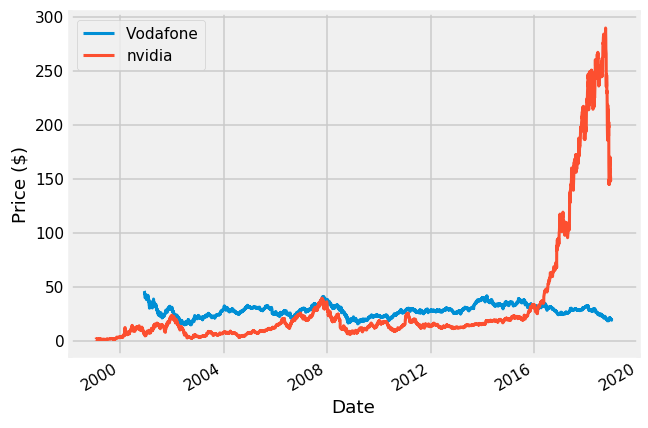

In [24]:
plt.figure()
data_vod["Close"].plot(label="Vodafone")
data_nvda["Close"].plot(label="nvidia")
plt.legend()
plt.ylabel("Price ($)")
plt.tight_layout()

Welchen Gewinn hätte ich gemacht wenn....???
An der Stelle haben wir im Workshop auch Dividendenausschüttungen diskutiert, die genau in diesem Fall auch das Ergebnis beeinflussen. Nvidia schüttet nichts aus, Vodafone schon. Das beeinflusst auch den Börsenwert und verzerrt den Vergleich. Wird hier nicht weiter berücksichtigt ist aber wichtig zu wissen.

## Performanceberechnung

Beispiel NVIDIA, Viele machen ihr machine learning und Ihre Trainingsvorgänge auf NVIDIA Grafikkarten, spielen seit Jahren auf Nvidia Grafikkarten, haben schon viel Geld in invidia Hardware investiert und ärgern sich wie teuer die sind: NVidia Kurs:

In [25]:
from pandas_datareader import data as pdr
import pandas as pd
import matplotlib.pyplot as plt
import fix_yahoo_finance as yf
#plt.xkcd()
#%matplotlib notebook
yf.pdr_override() 
stock_list = []

def plot_performance(stocks, start, end):
    stock_list = []
    for stock in stocks:
        stock_list.append(pdr.get_data_yahoo(stock,start,end)["Close"])
    df = pd.concat(tuple(stock_list), axis=1, keys=stocks)
    stocks_return = df.apply(lambda x: 1*x/x[0])# *1 für Bezug zu Anfangswert 1
    return stocks_return

def plot_stock_values(stocks, start, end):
    stock_list = []
    for stock in stocks:
        stock_list.append(pdr.get_data_yahoo(stock,start,end)["Close"])
    df = pd.concat(tuple(stock_list), axis=1, keys=stocks)
    stocks_return = df
    return stocks_return

def plot_edelm(edelm, start, end):
    return pdr.get_data_yahoo(stock,start,end)
   

[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded


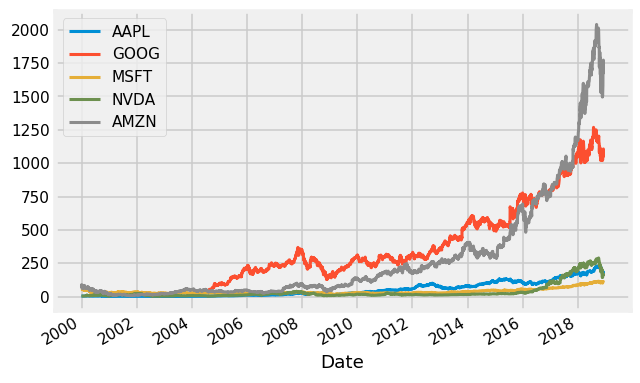

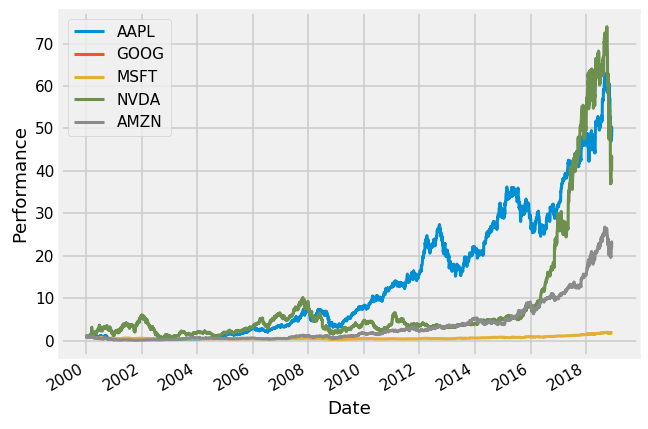

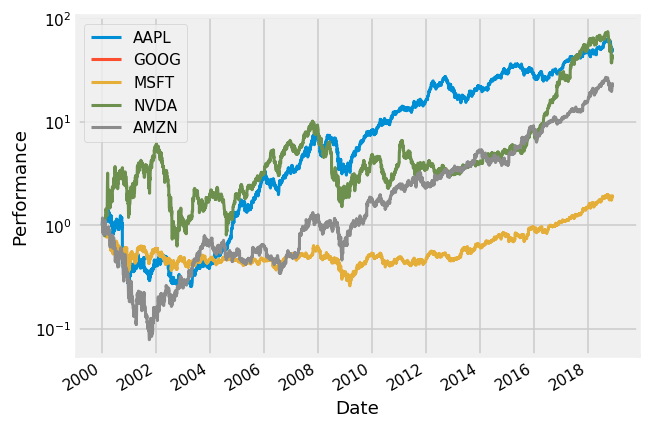

In [26]:
stocks = ["AAPL","GOOG","MSFT","NVDA", "AMZN"]
temporal_range = ['2000-01-01', "2018-12-05"]
df = plot_performance(stocks,start=temporal_range[0], end=temporal_range[1])
df_values = plot_stock_values(stocks,start=temporal_range[0], end=temporal_range[1])
df_values.plot(logy=False)
df.plot(logy=False)
plt.ylabel("Performance")
plt.tight_layout()
df.plot(logy=True)
plt.ylabel("Performance")
plt.tight_layout()
#df_values.plot()
#plt.figure("a")
#plt.plot(df["MSCI"])

Das war nur die Hälfte der Wahrheit....

- Deutsche Bank Aktien
- Dotcom Blase
- Immobilienmarktkrise 2008
- Ölkrise
- Krise, Krise, Krise...

## Streuen des Risikos: Diversifikation

Apple, Johnson&Johnson, MMM, McDonalds, Procter&Gamble, Coca Cola, Walmart, Exxon, Boeing

[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*******************

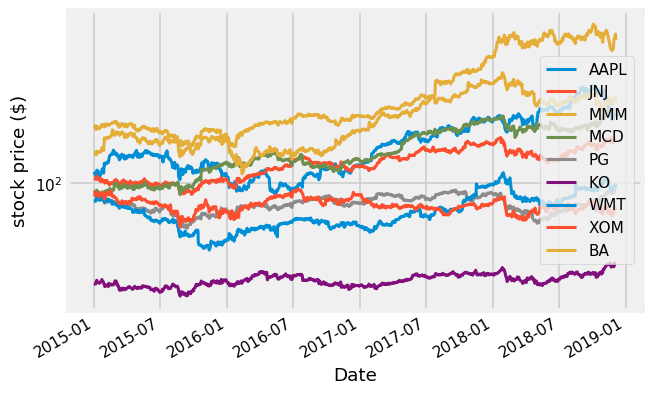

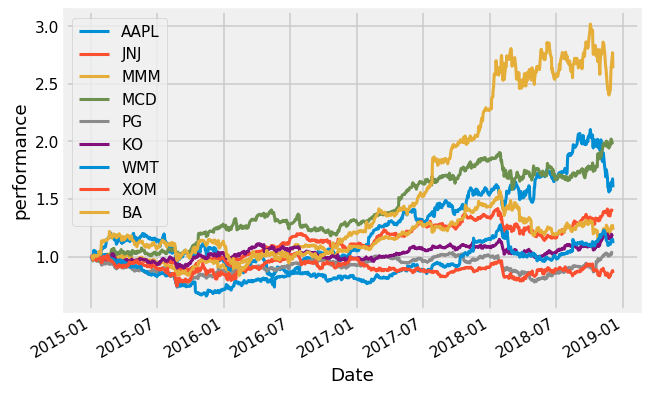

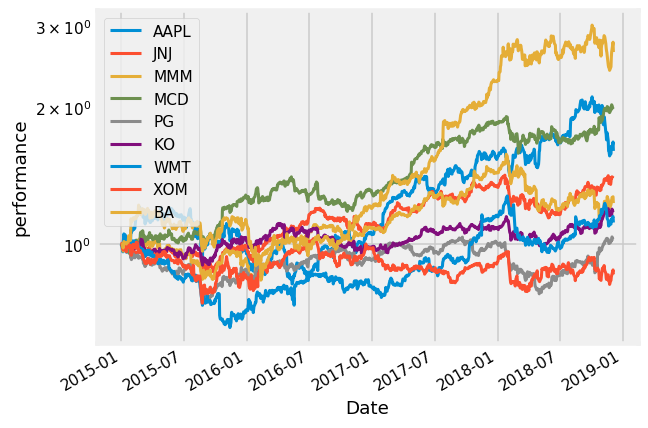

In [27]:
stocks = ["AAPL","JNJ","MMM","MCD", "PG", "KO","WMT","XOM","BA"]
temporal_range = ['2015-01-01', "2018-12-05"]
df_values = plot_stock_values(stocks,start=temporal_range[0], end=temporal_range[1])
df = plot_performance(stocks,start=temporal_range[0], end=temporal_range[1])
print(df.head())
print(df_values.head())
fig, ax1 = plt.subplots(num="stock price log scale")
df_values.plot(ax=ax1, logy=True)
ax1.set_ylabel("stock price ($)")
fig, ax2 = plt.subplots(num="Performance lin-scale")
df.plot(ax=ax2,logy=False)
ax2.set_ylabel("performance")
fig, ax3 = plt.subplots(num="Performance log-scale")
df.plot(ax=ax3,logy=True)
ax3.set_ylabel("performance")
plt.tight_layout()


In [28]:
list(df)

['AAPL', 'JNJ', 'MMM', 'MCD', 'PG', 'KO', 'WMT', 'XOM', 'BA']

### Korrelation verschiedener Zeitserien

Diesen Teil habe ich im Workshop übersprungen, man kann die Korrelation verschiedener Preisdaten innerhalb eines Zeitraumes berechnen und darstellen.

          AAPL       JNJ       MMM       MCD        PG        KO       WMT  \
AAPL  1.000000  0.732543  0.747959  0.801665  0.139760  0.509861  0.798090   
JNJ   0.732543  1.000000  0.917111  0.921561  0.568407  0.787830  0.709361   
MMM   0.747959  0.917111  1.000000  0.880133  0.449765  0.655814  0.770623   
MCD   0.801665  0.921561  0.880133  1.000000  0.327418  0.784662  0.689145   
PG    0.139760  0.568407  0.449765  0.327418  1.000000  0.506788  0.329764   
KO    0.509861  0.787830  0.655814  0.784662  0.506788  1.000000  0.570133   
WMT   0.798090  0.709361  0.770623  0.689145  0.329764  0.570133  1.000000   
XOM  -0.320323 -0.065423 -0.108918 -0.285840  0.324658  0.027876 -0.013953   
BA    0.944591  0.754950  0.797365  0.861921  0.061007  0.556016  0.815201   

           XOM        BA  
AAPL -0.320323  0.944591  
JNJ  -0.065423  0.754950  
MMM  -0.108918  0.797365  
MCD  -0.285840  0.861921  
PG    0.324658  0.061007  
KO    0.027876  0.556016  
WMT  -0.013953  0.815201  
XOM

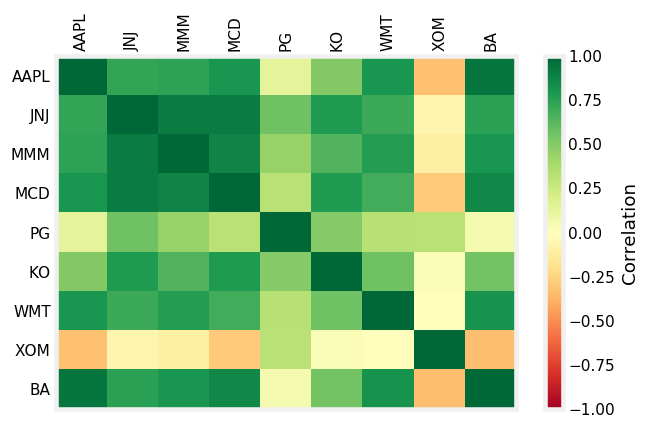

In [29]:
def visualize_data():
    df_corr = df_values.corr()
    print(df_corr)
    df_corr.to_csv('sp500corr.csv')
    data1 = df_corr.values
    fig1 = plt.figure("Correlation")
    ax1 = fig1.add_subplot(111)
    heatmap1 = ax1.pcolor(data1, cmap=plt.cm.RdYlGn)
    cb = fig1.colorbar(heatmap1)
    ax1.set_xticks(np.arange(data1.shape[1]) + 0.5, minor=False)
    ax1.set_yticks(np.arange(data1.shape[0]) + 0.5, minor=False)
    ax1.invert_yaxis()
    ax1.xaxis.tick_top()
    column_labels = df_corr.columns
    row_labels = df_corr.index
    ax1.set_xticklabels(column_labels)
    ax1.set_yticklabels(row_labels)
    plt.xticks(rotation=90)
    heatmap1.set_clim(-1,1)
    cb.ax.set_ylabel('Correlation')
    plt.tight_layout()
    
visualize_data()

### Berechnen eines *Durchschnittswertes*

In [30]:
indexSeries = pd.DataFrame()
indexSeries["index"] = df_values.mean(axis=1)
indexSeries.plot(ax=ax1, legend=True, lw=4, color="k")

### Berechnen eines *Durchschnittswertes* (Performance)

In [31]:
indexSeries = pd.DataFrame()
indexSeries["index"] = df.mean(axis=1)
indexSeries.plot(ax=ax2, legend=True, lw=4, ls='-',color="k")
indexSeries.plot(ax=ax3, legend=True, lw=4, ls='-',color="k")

Besonderheit: 
- Durchschnittswerte der Kurse nicht repräsentativ:
- Aktienkurse sind *willkürlich* hoch: Der Unternehmenswert (Marktkapitalisiserung) ermittelt sich aus dem Produkt der vorhandenen Aktien und dem Stückpreis
- Kurse werden typischerweise nach Marktkapitalisierung gewichtet.

# Aktienfonds

Produkt um die Vorteile gemeinsamen Investieren zu nutzen.

### DowJones

In [32]:
data_dow_yahoo = pdr.get_data_yahoo("^DJI","1970-12-12","2018-12-14")
data_dow_alpha = pdr.get_data_alphavantage("^DJI",function='TIME_SERIES_DAILY',
                                             start="1970-12-12",end="2018-12-14", api_key="1X6D9DKKAQD7BPWV")
dow = quandl.get("BCB/UDJIAD1")

[*********************100%***********************]  1 of 1 downloaded


In [33]:
dow = quandl.get("BCB/UDJIAD1")

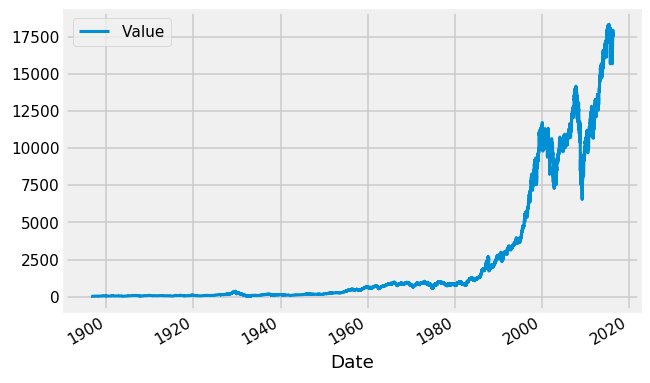

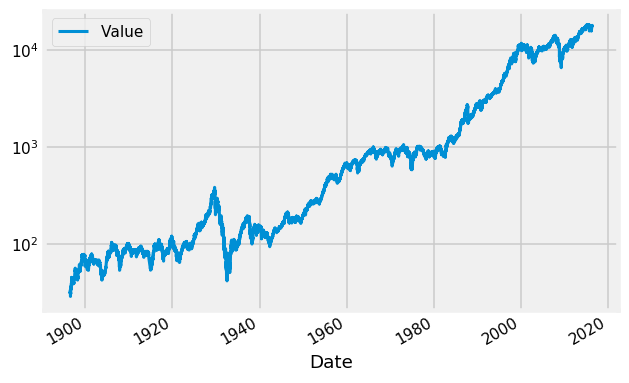

In [34]:
dow.plot()
dow.plot(logy=True)

In [35]:
dow.head()

,Value
Date,
1896-07-14,33.43
1896-07-15,32.28
1896-07-16,31.95
1896-07-17,31.94
1896-07-18,31.50


## Wann Einsteigen, wann Aussteigen? 

### Ich will market timing spielen, der Gesamtmarkt ist grad so teuer, das ist bestimmt eine Blase

Franz, ich will da jetzt nicht einsteigen, es ist alles viel zu teuer!!!

Zu tun: Renditedreieck berechnen, auf Zeit spielen
Kumulative Funktion schreiben mit Buchungen und Ertrag

## Jetzt wird's konkret - der Sparplan

Berechnung eines Sparplanes

pip install -e git://github.com/better/irr#egg=irr

2018-1973

Bin selbst etwas über 30, noch 35 Jahre "bis zur Rente"!

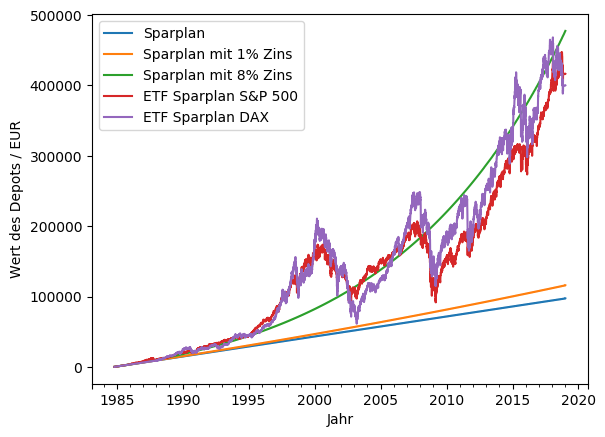

In [36]:
import os

begin_date = pd.Timestamp("1984-10-30")
end_date = pd.Timestamp("2019-01-03")
initial_balance = 0.0
interest = 0.0 #percent
deposit = 237.0
CC = CumulativeCalculation(initial_balance, begin_date, end_date, deposit, "MS", interest)
CC1 = CumulativeCalculation(initial_balance, begin_date, end_date, deposit, "MS", interest+1.0)
CC8 = CumulativeCalculation(initial_balance, begin_date, end_date, deposit, "MS", interest+8.0)


CCS = CumulativeStockCalculation("yahoo","^GSPC",initial_balance, begin_date, end_date, deposit, "MS")
CCDAX = CumulativeStockCalculation("yahoo","^GDAXI",initial_balance, begin_date, end_date, deposit, "MS")
CCAAPL = CumulativeStockCalculation("yahoo","AAPL",initial_balance, begin_date, end_date, deposit, "MS")
CCAAPL_quandl = CumulativeStockCalculation("quandl","WGC/GOLD_DAILY_USD",initial_balance, begin_date, end_date, deposit, "MS")

CC.calc_interest()
CC8.calc_interest()
CCS.calc_interest()
CCDAX.calc_interest()
CCAAPL_quandl.calc_interest()
#CCAAPL.calc_interest()
CC1.calc_interest()
plt.style.use("default")
plt.figure(0)
CC.df["value"].plot(ls="-", label="Sparplan")
CC1.df["value"].plot(ls="-", label="Sparplan mit 1% Zins")
CC8.df["value"].plot(ls="-", label="Sparplan mit 8% Zins")
CCS.calc_interest()
CCS.df["value"].plot(label="ETF Sparplan S&P 500")
CCDAX.df["value"].plot(label="ETF Sparplan DAX")
#CCAAPL_quandl.df["value"].plot(label="Gold USD")
plt.xlabel("Jahr")
plt.ylabel("Wert des Depots / EUR")
#plt.grid(True)
plt.legend(loc="best")
#plt.figure(1)
#CCS.plot_stock()

Aufteilen des Sparplans in Einzahlperioden:
- monatliches Einzahlen

[2017, 2016, 2015, 2014, 2013, 2012, 2011, 2010, 2009, 2008, 2007, 2006, 2005, 2004, 2003, 2002, 2001, 2000, 1999, 1998, 1997, 1996, 1995, 1994, 1993, 1992, 1991, 1990, 1989, 1988, 1987, 1986, 1985, 1984, 1983]
[2018, 2017, 2016, 2015, 2014, 2013, 2012, 2011, 2010, 2009, 2008, 2007, 2006, 2005, 2004, 2003, 2002, 2001, 2000, 1999, 1998, 1997, 1996, 1995, 1994, 1993, 1992, 1991, 1990, 1989, 1988, 1987, 1986, 1985, 1984]


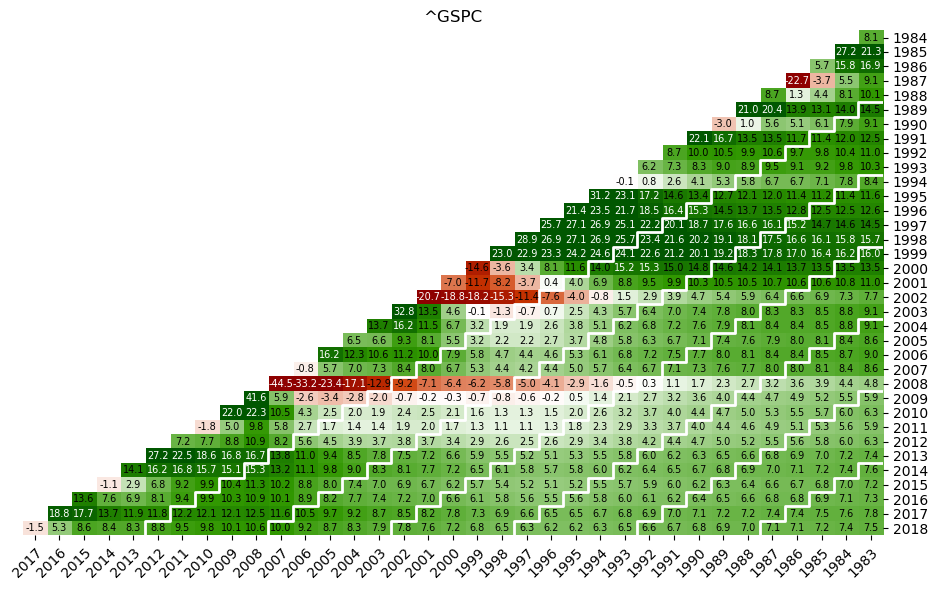

In [37]:
my_dreieck = RenditeDreieck("yahoo_finance", "^GSPC", begin_date, end_date, deposit, "MS", "Y")
dreieck = my_dreieck.calc_triangle(True)
my_dreieck.plot_triangle()


[2017, 2016, 2015, 2014, 2013, 2012, 2011, 2010, 2009, 2008, 2007, 2006, 2005, 2004, 2003, 2002, 2001, 2000, 1999, 1998, 1997, 1996, 1995, 1994, 1993, 1992, 1991, 1990, 1989, 1988, 1987, 1986, 1985, 1984, 1983]
[2018, 2017, 2016, 2015, 2014, 2013, 2012, 2011, 2010, 2009, 2008, 2007, 2006, 2005, 2004, 2003, 2002, 2001, 2000, 1999, 1998, 1997, 1996, 1995, 1994, 1993, 1992, 1991, 1990, 1989, 1988, 1987, 1986, 1985, 1984]


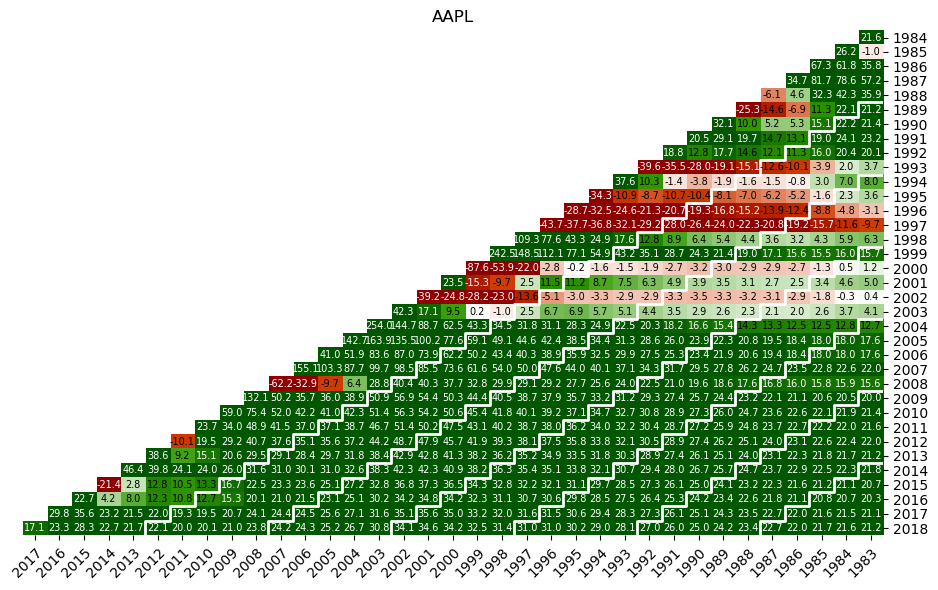

In [38]:
my_dreieck = RenditeDreieck("yahoo_finance", "AAPL", begin_date, end_date, deposit, "MS", "Y")
dreieck = my_dreieck.calc_triangle(True)
my_dreieck.plot_triangle()

[2017, 2016, 2015, 2014, 2013, 2012, 2011, 2010, 2009, 2008, 2007, 2006, 2005, 2004, 2003, 2002, 2001, 2000, 1999, 1998, 1997, 1996, 1995, 1994, 1993, 1992, 1991, 1990, 1989, 1988, 1987, 1986, 1985, 1984, 1983]
[2018, 2017, 2016, 2015, 2014, 2013, 2012, 2011, 2010, 2009, 2008, 2007, 2006, 2005, 2004, 2003, 2002, 2001, 2000, 1999, 1998, 1997, 1996, 1995, 1994, 1993, 1992, 1991, 1990, 1989, 1988, 1987, 1986, 1985, 1984]
0 4
5 10
22 27
24 31


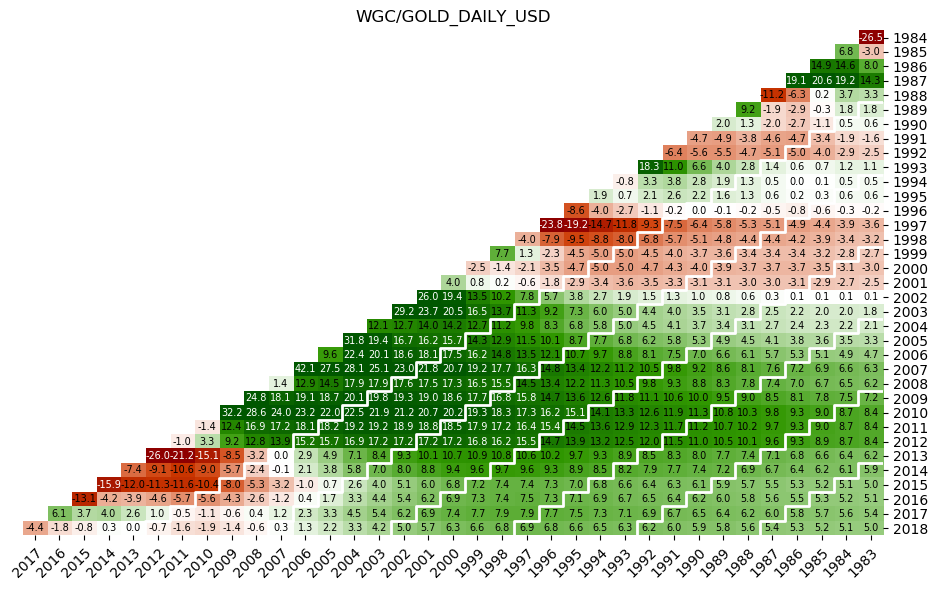

In [39]:
my_dreieck = RenditeDreieck("quandl", "WGC/GOLD_DAILY_USD", begin_date, end_date, deposit, "MS", "Y")
dreieck = my_dreieck.calc_triangle(True)
my_dreieck.plot_triangle()

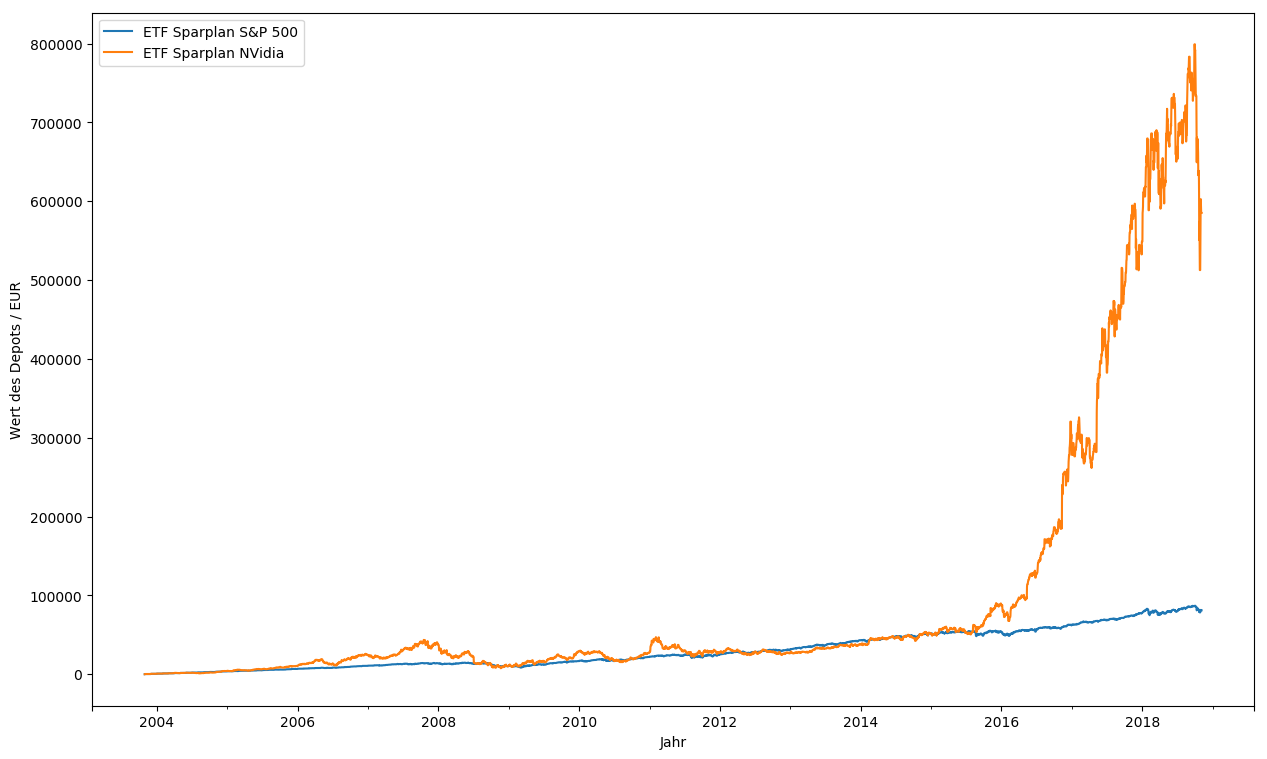

In [40]:
begin_date = pd.Timestamp("2003-10-30")
end_date = pd.Timestamp("2018-11-05")
initial_balance = 0.0
interest = 0.0 #percent
deposit = 237.0
CC = CumulativeCalculation(initial_balance, begin_date, end_date, deposit, "MS", interest)
CC1 = CumulativeCalculation(initial_balance, begin_date, end_date, deposit, "MS", interest+1.0)
CC8 = CumulativeCalculation(initial_balance, begin_date, end_date, deposit, "MS", interest+8.0)


CCS = CumulativeStockCalculation("yahoo","^GSPC",initial_balance, begin_date, end_date, deposit, "MS")
CCNVDA = CumulativeStockCalculation("yahoo","NVDA",initial_balance, begin_date, end_date, deposit, "MS")
CCAAPL = CumulativeStockCalculation("yahoo","AAPL",initial_balance, begin_date, end_date, deposit, "MS")
CCAAPL_quandl = CumulativeStockCalculation("quandl","WGC/GOLD_DAILY_USD",initial_balance, begin_date, end_date, deposit, "MS")

CC.calc_interest()
CC8.calc_interest()
CCS.calc_interest()
CCNVDA.calc_interest()
CCAAPL_quandl.calc_interest()
#CCAAPL.calc_interest()
CC1.calc_interest()
plt.style.use("default")
plt.figure(0, figsize=(15,9))
#CC.df["value"].plot(ls="-", label="Sparplan")
#CC1.df["value"].plot(ls="-", label="Sparplan mit 1% Zins")
#CC8.df["value"].plot(ls="-", label="Sparplan mit 8% Zins")
CCS.calc_interest()
CCS.df["value"].plot(label="ETF Sparplan S&P 500")
CCNVDA.df["value"].plot(label="ETF Sparplan NVidia")
#CCAAPL_quandl.df["value"].plot(label="Gold USD")
plt.xlabel("Jahr")
plt.ylabel("Wert des Depots / EUR")
#plt.grid(True)
plt.legend(loc="best")
#plt.figure(1)
#CCS.plot_stock()

[2016, 2015, 2014, 2013, 2012, 2011, 2010, 2009, 2008, 2007, 2006, 2005, 2004, 2003, 2002]
[2017, 2016, 2015, 2014, 2013, 2012, 2011, 2010, 2009, 2008, 2007, 2006, 2005, 2004, 2003]


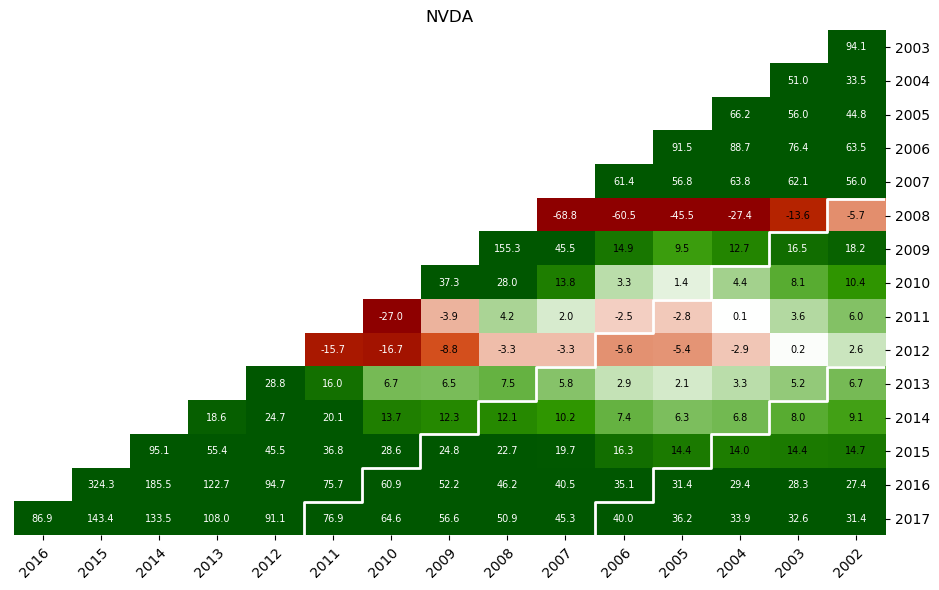

In [41]:
    my_dreieck = RenditeDreieck("yahoo", "NVDA", begin_date, end_date, deposit, "MS", "Y")
    dreieck = my_dreieck.calc_triangle(True)
    my_dreieck.plot_triangle()

[2016, 2015, 2014, 2013, 2012, 2011, 2010, 2009, 2008, 2007, 2006, 2005, 2004, 2003, 2002, 2001, 2000, 1999, 1998, 1997]
[2017, 2016, 2015, 2014, 2013, 2012, 2011, 2010, 2009, 2008, 2007, 2006, 2005, 2004, 2003, 2002, 2001, 2000, 1999, 1998]


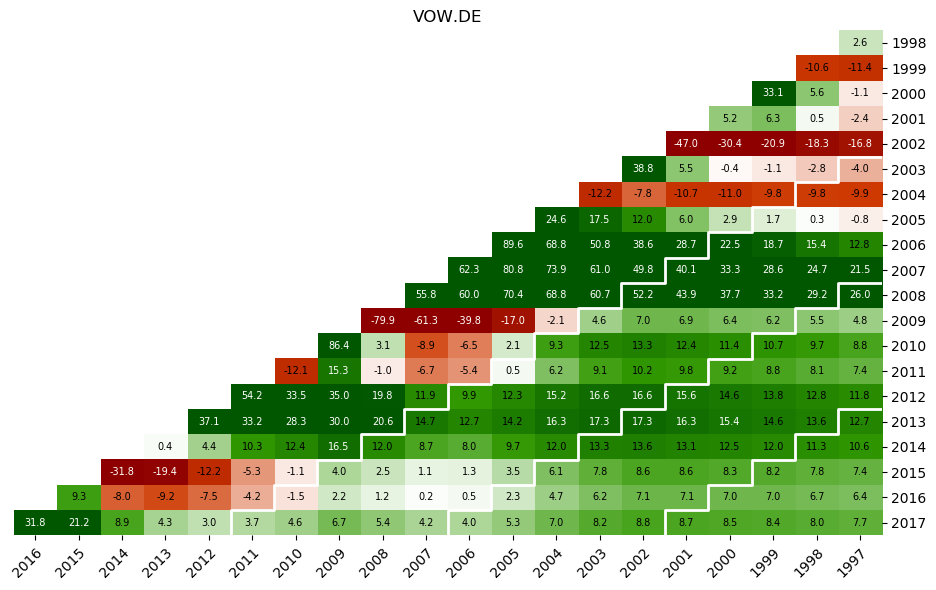

In [42]:
    my_dreieck = RenditeDreieck("yahoo", "VOW.DE", "1998-01-01", "2018-11-05", 1000, "MS", "Y")
    dreieck = my_dreieck.calc_triangle(True)
    my_dreieck.plot_triangle()

[2016, 2015, 2014, 2013, 2012, 2011, 2010, 2009, 2008, 2007, 2006]
[2017, 2016, 2015, 2014, 2013, 2012, 2011, 2010, 2009, 2008, 2007]
1 2
10 10


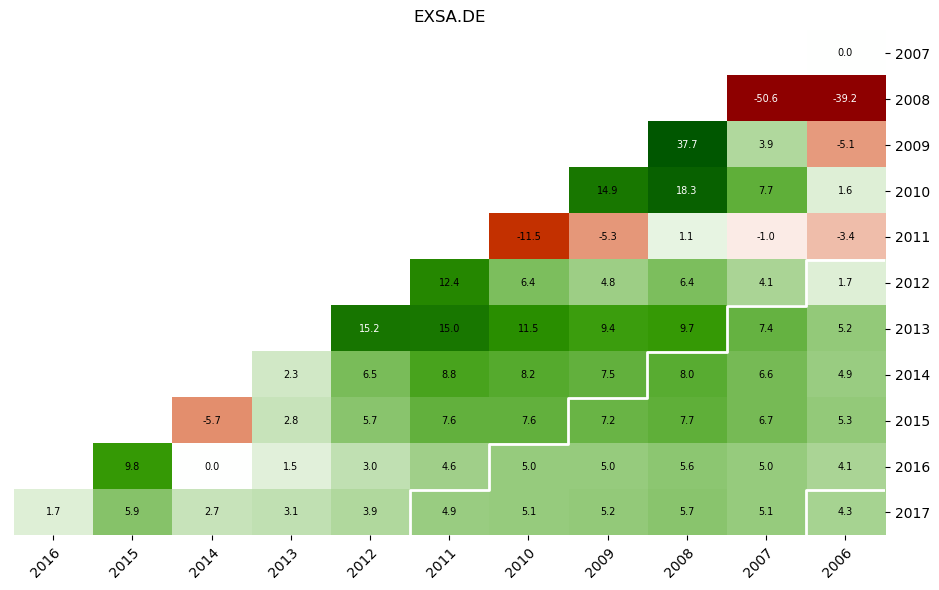

In [43]:
    my_dreieck = RenditeDreieck("yahoo", "EXSA.DE", "2007-01-01", "2018-11-05", 1000, "MS", "Y")
    dreieck = my_dreieck.calc_triangle(True)
    my_dreieck.plot_triangle()

Es gibt noch dutzendes zu bedenken:
- Währung?
- Steuern? --> Steuergesetze ändern sich.
- 

### Internal Rate of Investment (IRR): Interner Zinsfuß

$$KW = -I+\sum_{t=1}^T \frac{C_t}{(1+\text{irr})^t} $$

$$KW \overset{!}{=} 0$$


$$\text{Entnahmesumme} = \frac{200}{r+1}+\frac{200}{(r+1)^2}+\frac{200}{(r+1)^3}+... $$

## Der Dystopische Ansatz oder: was kann schief gehen?

Ob es ratsam ist in Aktien zu investieren hängt ganz wesentlich von der eigenen Weltsicht ab. Was passiert die nächsten 50 Jahre?

- Szenario 1: Die Welt geht unter! Postapokalypse: Es zählt was man kann und was man zu tauschen hat. Ich bin Vollzeitimker.
- Szenario 2: Diktatur und es ist verboten ausländische Aktien zu besitzen --> Wie sicher ist dann aber alles andere? Es war auch verboten Gold zu besitzen und Rente war auch nicht so sicher?! Man hat Glück wenn man mit dem Leben davonkommt.
- Szenario 3: Der Kapitalismus schafft sich selbst ab: Mit Aktien hat man dann Pech gehabt.
- Szenario 4: Es bleibt bei dem Trend, dass die Welt besser und weniger tödlich wird. (Kurve zeigen)
- 


# Was soll uns das alles?

- Ungleiche Vermögen und Einkommen spalten die Gesellschaft, das ist ein politisches Thema, das ich hier nicht adressiere
- Ungleiche Vermögen und Sparraten verstärken das Vermögensverhältnis infolge ungleich verteilter Finanzbildung
- Aus der Vergangenheit lassen sich keine Vorhersagen für die Zukunft des Aktienmarktes ableiten

# Twitter: ziergedeck, github: karpatenhuhn 

# beier@franzcloud.net